In [219]:
%matplotlib inline

import os, sys
import pandas as pd
import numpy as np
import stochastic
from scipy import stats
from matplotlib import pyplot as plt
import graphs
plt.rcParams['figure.figsize'] = [10, 6]

def load_data(res_dir):
    data = pd.DataFrame()
    for filename in os.listdir(res_dir):
        if ".csv" in filename:
            data = pd.concat([data, pd.read_csv(os.path.join(res_dir, filename))])
    return data

def extract_mean_scores_data(list_data):
    res_data = list_data.copy()
    score_cols = [col for col in res_data.columns if "scores" in col]
    res_data[score_cols] = res_data[score_cols].apply(lambda col: col.apply(
        lambda val_list: np.nanmean(eval(str(val_list).replace("nan", "np.nan")))), axis=1)
    return res_data
    
def extract_vertex_scores_data(list_data):
    res_data = []
    score_cols = [col for col in list_data.columns if "scores" in col]
    non_score_cols = [col for col in list_data if col not in score_cols]
    for index, row in list_data.iterrows():
        val_lists = [eval(str(val_list).
                          replace("nan", "np.nan")) for val_list in row[score_cols]]
        for vals in zip(*val_lists):
            if not np.isnan(vals[0]):
                res_data.append(list(row[non_score_cols]) + list(vals))
    res_data = pd.DataFrame(res_data)
    res_data.columns = non_score_cols + score_cols
    return res_data

def treat_unequal_representation(data, min_threshold=0.8):
    # TODO: rewrite this horror of a code
    res_data = pd.DataFrame()
    n_rnds = []
    for graph_name in data.graph_name.unique():
        n_bio = len(data.loc[(data.graph_name == graph_name) & (data.is_random == False)])
        n_rnd = len(data.loc[(data.graph_name == graph_name) & (data.is_random == True)])
        assert n_bio <= 1
#         print "{}: #bio={}, #rnd={}".format(graph_name, n_bio, n_rnd)
        if n_bio == 1:
            res_data = pd.concat([res_data, data[data.graph_name == graph_name]])
        n_rnds.append(n_rnd)
    
    final_res_data = pd.DataFrame()
    for graph_name in res_data.graph_name.unique():
        n_rnd = len(res_data.loc[(res_data.graph_name == graph_name) & (res_data.is_random == True)])
        if n_rnd >= max(n_rnds) * 0.8:
            final_res_data = pd.concat([final_res_data, res_data.loc[(res_data.graph_name == graph_name)]])    
    
    return final_res_data

def convert_model_addition_scores(data, K=30): 
    # because I have to ways to normalize that, and want to be able to convert here from 1/K to 1/ATT
    data['optimization_model_addition_impact_scores'] = data['optimization_model_addition_impact_scores'] * K / data['num_attractors']
    return data

In [220]:
data = treat_unequal_representation(load_data("results/29_10_pooled"), min_threshold=0.8)
mean_data = extract_mean_scores_data(data)
vertex_data = extract_vertex_scores_data(data)

mean_data = convert_model_addition_scores(mean_data)
vertex_data = convert_model_addition_scores(vertex_data)

score_types = [col for col in data if "scores" in col]
print "number of graphs: {}".format(len(data.graph_name.unique()))
print "#bio={}, #rnd={}".format(len(data.loc[data.is_random == False]), len(data.loc[data.is_random == True]))

number of graphs: 24
#bio=24, #rnd=72


## mean

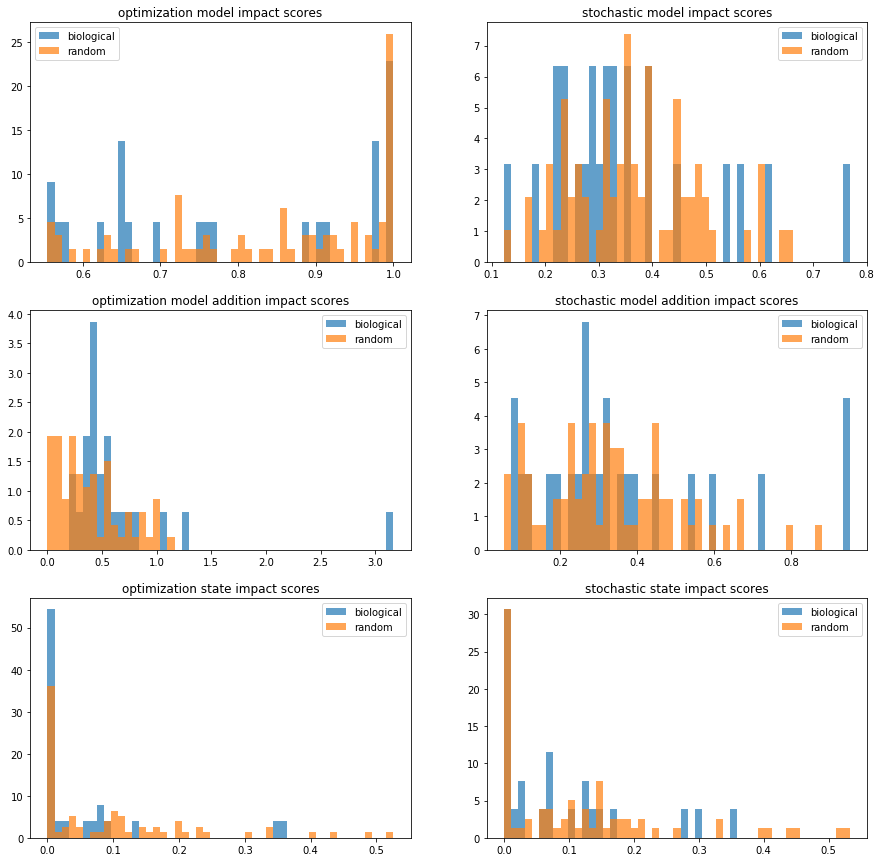

In [221]:
fig, ax = plt.subplots(nrows=len(score_types)/2, ncols=2, sharey=False, sharex=False, figsize=(15, 15))

i = 0
for score in score_types:
    bins = np.linspace(min(mean_data[score]), max(mean_data[score]), 50)
    cur_ax = ax[i / 2, i % 2]
    for is_random in [False, True]:
        cur_ax.hist(mean_data.loc[mean_data.is_random == is_random][score], alpha=0.7, bins=bins, density=True)
    cur_ax.legend(["biological", "random"])
    cur_ax.set_title(score.replace("_", " "))
    i += 1
plt.show()

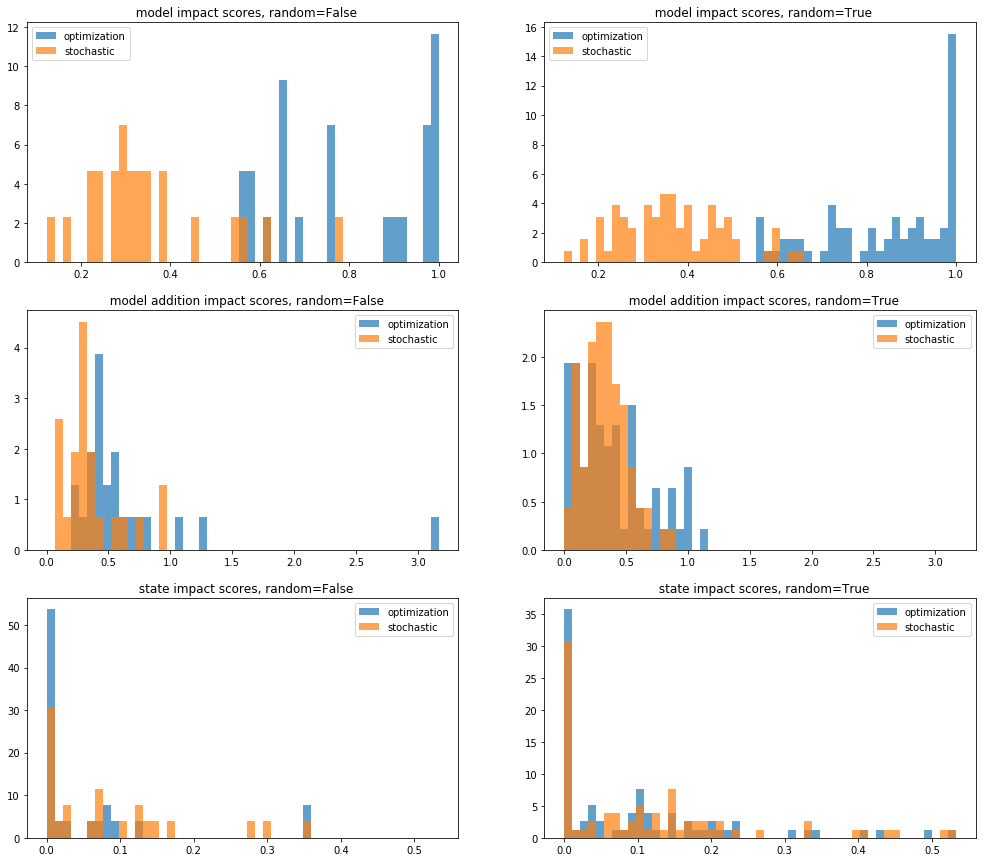

In [222]:
fig, ax = plt.subplots(nrows=len(score_types)/2, ncols=2, sharey=False, sharex=False, figsize=(17, 15))

i = 0
score_pairs = [(s, s.replace("optimization", "stochastic")) for s in score_types if "optimization" in s]
for score_pair in score_pairs:
    for is_random in [False, True]:
        bins = np.linspace(min(min(mean_data[score_pair[0]]), min(mean_data[score_pair[1]])), 
                           max(max(mean_data[score_pair[0]]), max(mean_data[score_pair[1]])), 50)
        cur_ax = ax[i / 2, i % 2]
        for score in score_pair:
            cur_ax.hist(mean_data.loc[mean_data.is_random == is_random][score], alpha=0.7, bins=bins, density=True)
        cur_ax.legend(["optimization", "stochastic"])
        cur_ax.set_title("{}, random={}".format(score_pair[0].replace("optimization", " ").replace("_", " "), is_random))
        i += 1
plt.show()

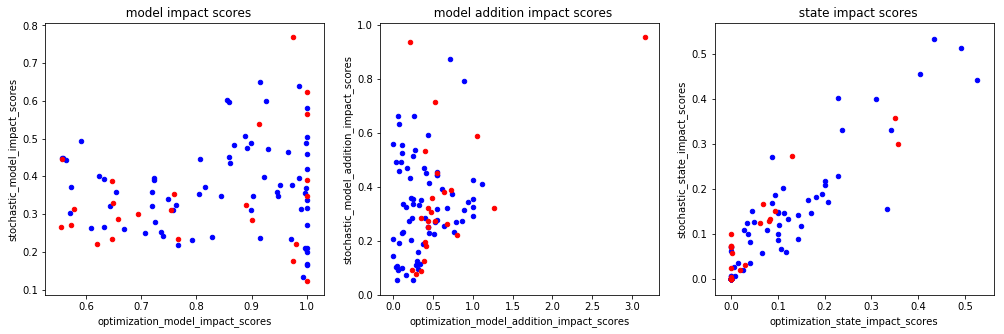

In [223]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharey=False, sharex=False, figsize=(17, 5))

i = 0
score_pairs = [(s, s.replace("optimization", "stochastic")) for s in score_types if "optimization" in s]
for score_pair in score_pairs:
    cur_ax = ax[i]
    mean_data.loc[mean_data.is_random == True].plot.scatter(x=score_pair[0], y=score_pair[1], c="blue", ax=cur_ax)
    mean_data.loc[mean_data.is_random == False].plot.scatter(x=score_pair[0], y=score_pair[1], c="red", ax=cur_ax)
    cur_ax.set_title(score_pair[0].replace("optimization", " ").replace("_", " "))
    i += 1
plt.show()

In [224]:
for score in score_types:
    bio = mean_data.loc[mean_data.is_random == False][score]
    rnd = mean_data.loc[mean_data.is_random == True][score]
    print "{}\t\t biological={:.3f}\t random={:.3f} p_value={:.3e}".format(score, np.nanmean(bio), np.nanmean(rnd),
                                                                                 stats.mannwhitneyu(bio, rnd)[1])


optimization_model_impact_scores		 biological=0.795	 random=0.843 p_value=1.766e-01
stochastic_model_impact_scores		 biological=0.346	 random=0.367 p_value=1.029e-01
optimization_model_addition_impact_scores		 biological=0.636	 random=0.388 p_value=4.195e-03
stochastic_model_addition_impact_scores		 biological=0.357	 random=0.335 p_value=4.278e-01
optimization_state_impact_scores		 biological=0.053	 random=0.099 p_value=4.106e-02
stochastic_state_impact_scores		 biological=0.087	 random=0.118 p_value=2.388e-01


In [205]:
bio = mean_data.loc[mean_data.is_random == False]
rnd = mean_data.loc[mean_data.is_random == True]
for score in score_types:
    print score
    for field in [col for col in data.columns if ("scores" not in col) and ("time" not in col) and data[col].dtype in [np.int, np.float]]:
        print "{}\t biological corr={:.2f}\t random corr={:.2f}".format(field, np.corrcoef(bio[score], bio[field])[1,0], np.corrcoef(rnd[score], rnd[field])[1,0])
    print ""


optimization_model_impact_scores
normalized_n_inputs	 biological corr=-0.72	 random corr=-0.67
mean_degree	 biological corr=0.28	 random corr=0.33
mean_attractor_length	 biological corr=0.70	 random corr=0.32
median_attractor_length	 biological corr=0.73	 random corr=0.38
std_attractor_length	 biological corr=0.58	 random corr=-0.03
std_attractor_basin	 biological corr=0.43	 random corr=0.34
median_attractor_basin	 biological corr=0.63	 random corr=0.62
max_attractor_basin	 biological corr=0.82	 random corr=0.75

stochastic_model_impact_scores
normalized_n_inputs	 biological corr=-0.25	 random corr=-0.38
mean_degree	 biological corr=-0.70	 random corr=-0.54
mean_attractor_length	 biological corr=0.58	 random corr=0.36
median_attractor_length	 biological corr=0.51	 random corr=0.35
std_attractor_length	 biological corr=0.66	 random corr=0.11
std_attractor_basin	 biological corr=-0.17	 random corr=0.04
median_attractor_basin	 biological corr=0.09	 random corr=0.14
max_attractor_basin	 bi

## VERTEX

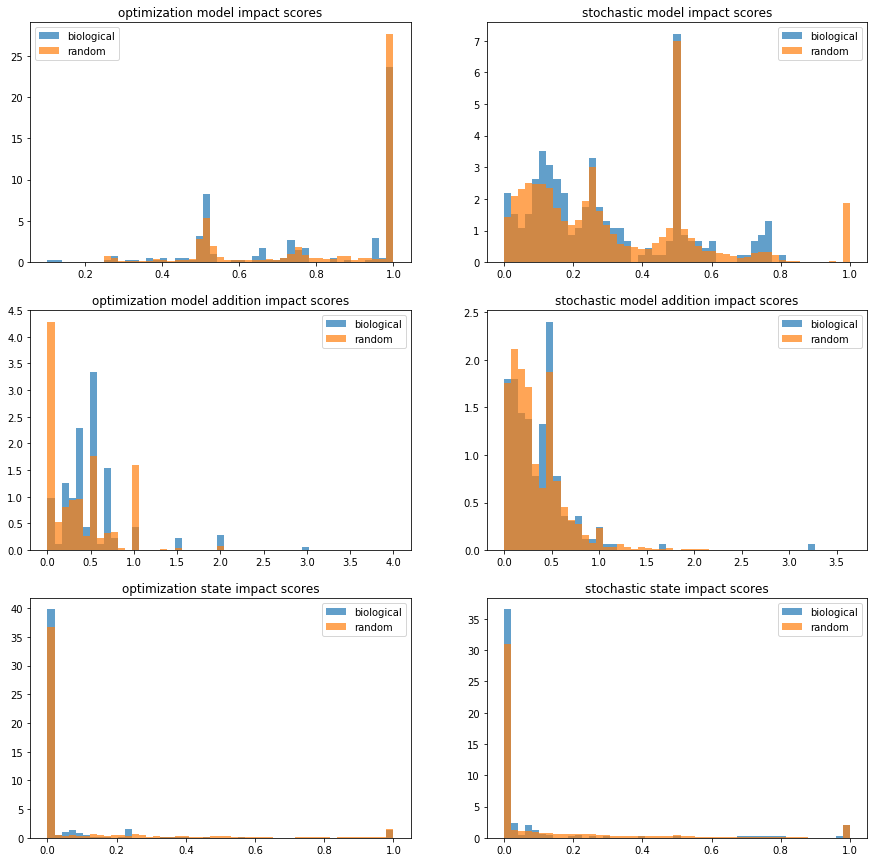

In [216]:
fig, ax = plt.subplots(nrows=len(score_types)/2, ncols=2, sharey=False, sharex=False, figsize=(15, 15))

i = 0
for score in score_types:
    bins = np.linspace(min(vertex_data[score]), max(vertex_data[score]), 50)
    cur_ax = ax[i / 2, i % 2]
    for is_random in [False, True]:
        cur_ax.hist(vertex_data.loc[vertex_data.is_random == is_random][score], alpha=0.7, bins=bins, density=True)
    cur_ax.legend(["biological", "random"])
    cur_ax.set_title(score.replace("_", " "))
    i += 1
plt.show()

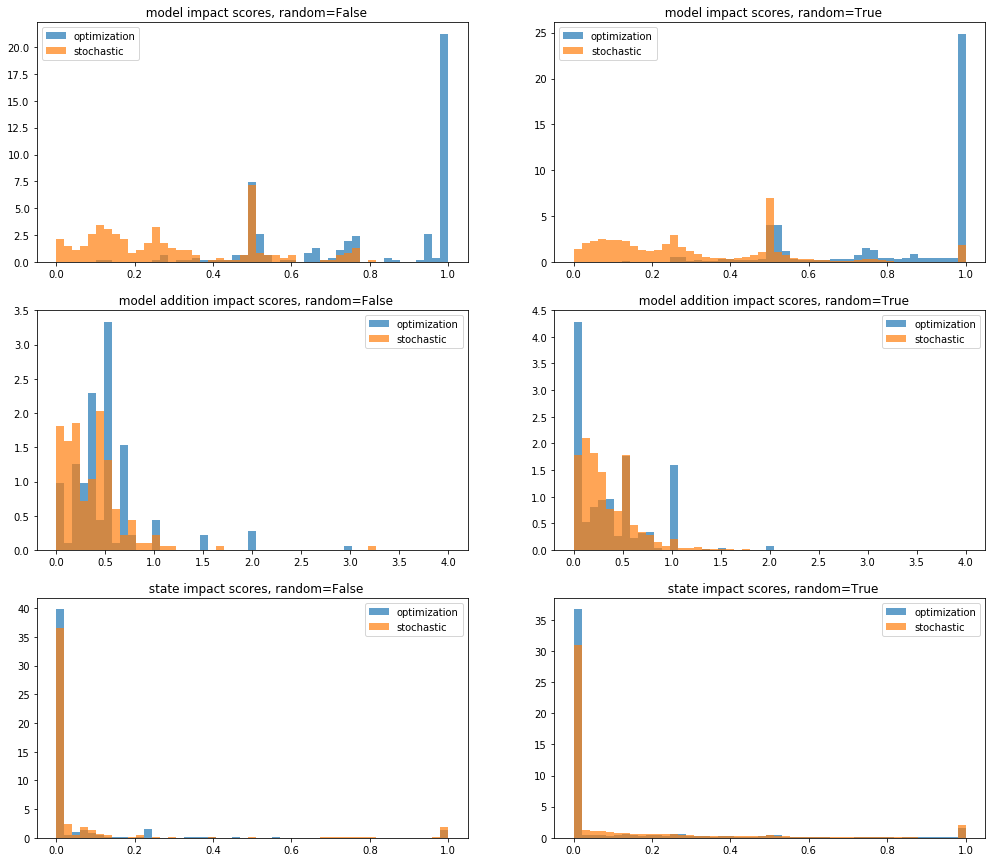

In [217]:
fig, ax = plt.subplots(nrows=len(score_types)/2, ncols=2, sharey=False, sharex=False, figsize=(17, 15))

i = 0
score_pairs = [(s, s.replace("optimization", "stochastic")) for s in score_types if "optimization" in s]
for score_pair in score_pairs:
    for is_random in [False, True]:
        bins = np.linspace(min(min(vertex_data[score_pair[0]]), min(vertex_data[score_pair[1]])), 
                           max(max(vertex_data[score_pair[0]]), max(vertex_data[score_pair[1]])), 50)
        cur_ax = ax[i / 2, i % 2]
        for score in score_pair:
            cur_ax.hist(vertex_data.loc[vertex_data.is_random == is_random][score], alpha=0.7, bins=bins, density=True)
        cur_ax.legend(["optimization", "stochastic"])
        cur_ax.set_title("{}, random={}".format(score_pair[0].replace("optimization", " ").replace("_", " "), is_random))
        i += 1
plt.show()

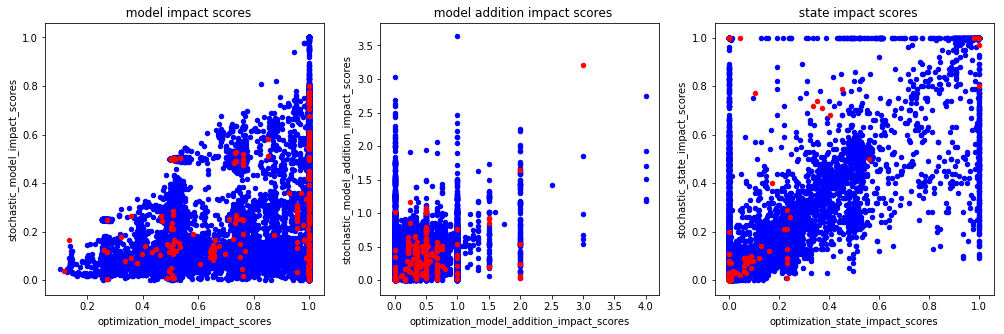

In [208]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharey=False, sharex=False, figsize=(17, 5))

i = 0
score_pairs = [(s, s.replace("optimization", "stochastic")) for s in score_types if "optimization" in s]
for score_pair in score_pairs:
    cur_ax = ax[i]
    vertex_data.loc[vertex_data.is_random == True].plot.scatter(x=score_pair[0], y=score_pair[1], c="blue", ax=cur_ax)
    vertex_data.loc[vertex_data.is_random == False].plot.scatter(x=score_pair[0], y=score_pair[1], c="red", ax=cur_ax)
    cur_ax.set_title(score_pair[0].replace("optimization", " ").replace("_", " "))
    i += 1
plt.show()

In [218]:
for score in score_types:
    bio = vertex_data.loc[vertex_data.is_random == False][score]
    rnd = vertex_data.loc[vertex_data.is_random == True][score]
    print "{}\t\t biological={:.3f}\t random={:.3f} p_value={:.3e}".format(score, np.nanmean(bio), np.nanmean(rnd),
                                                                                 stats.mannwhitneyu(bio, rnd)[1])


optimization_model_impact_scores		 biological=0.779	 random=0.806 p_value=5.784e-03
stochastic_model_impact_scores		 biological=0.293	 random=0.313 p_value=3.417e-01
optimization_model_addition_impact_scores		 biological=0.487	 random=0.357 p_value=1.013e-11
stochastic_model_addition_impact_scores		 biological=0.363	 random=0.340 p_value=1.500e-01
optimization_state_impact_scores		 biological=0.054	 random=0.105 p_value=1.847e-02
stochastic_state_impact_scores		 biological=0.088	 random=0.130 p_value=1.170e-03


In [212]:
bio = vertex_data.loc[vertex_data.is_random == False]
rnd = vertex_data.loc[vertex_data.is_random == True]
for score in score_types:
    print score
    for field in [col for col in data.columns if ("scores" not in col) and ("time" not in col) and data[col].dtype in [np.int, np.float]]:
        print "{}\t biological corr={:.2f}\t random corr={:.2f}".format(field, np.corrcoef(bio[score], bio[field])[1,0], np.corrcoef(rnd[score], rnd[field])[1,0])
    print ""


optimization_model_impact_scores
normalized_n_inputs	 biological corr=-0.48	 random corr=-0.39
mean_degree	 biological corr=0.13	 random corr=0.17
mean_attractor_length	 biological corr=0.53	 random corr=0.22
median_attractor_length	 biological corr=0.55	 random corr=0.25
std_attractor_length	 biological corr=0.44	 random corr=0.00
std_attractor_basin	 biological corr=0.23	 random corr=0.22
median_attractor_basin	 biological corr=0.40	 random corr=0.34
max_attractor_basin	 biological corr=0.55	 random corr=0.44

stochastic_model_impact_scores
normalized_n_inputs	 biological corr=-0.18	 random corr=-0.24
mean_degree	 biological corr=-0.47	 random corr=-0.33
mean_attractor_length	 biological corr=0.42	 random corr=0.21
median_attractor_length	 biological corr=0.37	 random corr=0.21
std_attractor_length	 biological corr=0.49	 random corr=0.06
std_attractor_basin	 biological corr=-0.13	 random corr=0.00
median_attractor_basin	 biological corr=0.06	 random corr=0.10
max_attractor_basin	 bio

## Timing and graph properties

In [213]:
timing_types = [score.replace("impact_scores", "time") for score in score_types]
for timing_type in timing_types:
    print timing_type
    print "median={:.2f}\tmean={:.2f}\tmax={:.2f}".format(np.nanmedian(data[timing_type]), np.nanmean(data[timing_type]),
                                                         np.nanmax(data[timing_type]))

optimization_model_time
median=0.47	mean=1.13	max=16.62
stochastic_model_time
median=3523.90	mean=3640.17	max=17146.06
optimization_model_addition_time
median=33.57	mean=132.50	max=7845.14
stochastic_model_addition_time
median=3440.70	mean=3507.19	max=13410.75
optimization_state_time
median=41.35	mean=279.21	max=7527.23
stochastic_state_time
median=5.10	mean=5.26	max=21.11


In [214]:
bio_properties = data.loc[data.is_random==False][[col for col in data.columns if (col not in score_types) and (
    col not in timing_types) and (col not in ["is_random", "maximal_change_bits"])]]
rnd_properties = data.loc[data.is_random==True][[col for col in data.columns if (col not in score_types) and (
    col not in timing_types) and (col not in ["is_random", "maximal_change_bits"])]]
bio_properties

,graph_name,size,n_inputs,normalized_n_inputs,max_degree,mean_degree,num_attractors,mean_attractor_length,median_attractor_length,std_attractor_length,max_attractor_length,std_attractor_basin,median_attractor_basin,max_attractor_basin
1,Body Segmentation in Drosophila 2013,17,3,0.176471,4,1.705882,10,1.00000,1.0,0.000000,1,0.045376,0.118129,0.138298
2,BT474 Breast Cell Line Short-term ErbB Network,16,5,0.312500,6,2.875000,84,1.00000,1.0,0.000000,1,0.012065,0.002377,0.036450
3,Cardiac development,15,1,0.066667,7,2.533333,6,1.00000,1.0,0.000000,1,0.116345,0.235097,0.268256
4,Cell Cycle Transcription by Coupled CDK and Ne...,9,0,0.000000,4,2.111111,2,3.00000,3.0,2.000000,5,0.268374,0.500000,0.768374
5,Cortical Area Development,5,0,0.000000,4,2.800000,2,1.00000,1.0,0.000000,1,0.375000,0.500000,0.875000
6,Fanconi anemia and checkpoint recovery,15,0,0.000000,8,4.400000,1,2.00000,2.0,0.000000,2,0.000000,1.000000,1.000000
7,HCC1954 Breast Cell Line Short-term ErbB Network,16,5,0.312500,6,2.875000,92,1.00000,1.0,0.000000,1,0.012520,0.002268,0.041572
8,Lac Operon,13,3,0.230769,4,1.692308,9,1.00000,1.0,0.000000,1,0.038435,0.124680,0.134927
9,Mammalian Cell Cycle,20,1,0.050000,5,2.550000,3,1.00000,1.0,0.000000,1,0.233914,0.491436,0.505929
10,Mammalian Cell Cycle 2006,10,0,0.000000,6,3.500000,2,4.00000,4.0,3.000000,7,0.014925,0.500000,0.514925


In [215]:
print "median num attractors:\t bio={:.2f}, rnd={:.2f}".format(np.median(bio_properties['num_attractors']), 
                                                                np.median(rnd_properties['num_attractors']))
print "mean num attractors:\t bio={:.2f}, rnd={:.2f}".format(np.mean(bio_properties['num_attractors']), 
                                                                np.mean(rnd_properties['num_attractors']))
print "average average attractor length:\t bio={:.2f}, rnd={:.2f}".format(np.mean(bio_properties['mean_attractor_length']), 
                                                                np.mean(rnd_properties['mean_attractor_length']))
print "average median attractor basin:\t bio={:.2f}, rnd={:.2f}".format(np.mean(bio_properties['median_attractor_basin']), 
                                                                np.mean(rnd_properties['median_attractor_basin']))
print "average max attractor basin:\t bio={:.2f}, rnd={:.2f}".format(np.mean(bio_properties['max_attractor_basin']), 
                                                                np.mean(rnd_properties['max_attractor_basin']))


median num attractors:	 bio=5.00, rnd=4.00
mean num attractors:	 bio=23.78, rnd=21.92
average average attractor length:	 bio=1.78, rnd=2.14
average median attractor basin:	 bio=0.27, rnd=0.29
average max attractor basin:	 bio=0.38, rnd=0.38


## JUNK

In [7]:
biological_graphs = []
biological_graph_names = []
candidate_biological_graph_names = os.listdir("cellcollective_models")
for graph_dir in candidate_biological_graph_names:
    try:
        G = graphs.Network.parse_boolean_tables(os.path.join("cellcollective_models", graph_dir))
        biological_graphs.append(G)
        biological_graph_names.append(graph_dir)
    except ValueError as e:
        if e.message.startswith("Model export from cellcollective failed"):
            print "warning - did not load graph {}".format(graph_dir)

graph_name_to_attributes = dict()
for i, graph, name in zip(range(len(biological_graphs)), biological_graphs, biological_graph_names):
    n_inputs = len([v for v in graph.vertices if len(v.predecessors()) == 0])
    max_degree = max([len(v.predecessors()) for v in graph.vertices])
    size = len(graph.vertices)
    mean_degree = sum([len(v.predecessors()) for v in graph.vertices]) / float(size)
    normaliezd_n_inputs = n_inputs / float(size)
    graph_name_to_attributes[name] = dict(n_inputs=n_inputs, max_degree=max_degree,
                                                size=size, mean_degree=mean_degree,
                                          normalized_n_inputs=normaliezd_n_inputs, G=graph)
    print "#{}; {} input nodes for graph {} of size {} and max degree {}".format(i, n_inputs, name,
                                                                                 size, max_degree)


#0; 2 input nodes for graph Apoptosis Network of size 41 and max degree 4
#1; 0 input nodes for graph Arabidopsis thaliana Cell Cycle of size 14 and max degree 8
#2; 4 input nodes for graph Aurora Kinase A in Neuroblastoma of size 23 and max degree 7
#3; 1 input nodes for graph B bronchiseptica and T retortaeformis coinfection of size 53 and max degree 8
#4; 5 input nodes for graph B cell differentiation of size 22 and max degree 7
#5; 3 input nodes for graph Body Segmentation in Drosophila 2013 of size 17 and max degree 4
#6; 0 input nodes for graph Bordetella bronchiseptica of size 33 and max degree 6
#7; 5 input nodes for graph Bortezomib Responses in U266 Human Myeloma Cells of size 67 and max degree 5
#8; 4 input nodes for graph BT474 Breast Cell Line Long-term ErbB Network of size 25 and max degree 6
#9; 5 input nodes for graph BT474 Breast Cell Line Short-term ErbB Network of size 16 and max degree 6
#10; 4 input nodes for graph Budding Yeast Cell Cycle of size 20 and max degree

24 49


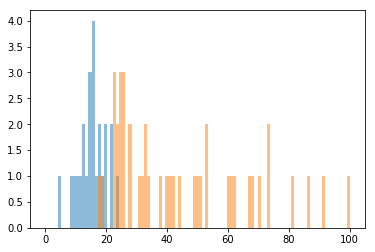

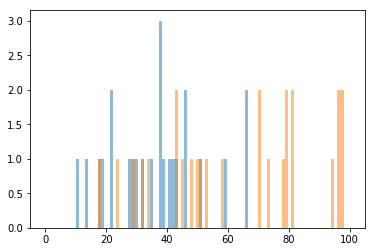

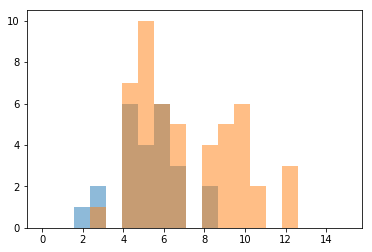

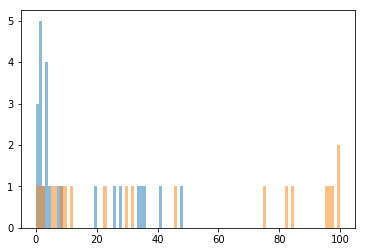

In [12]:
good_graphs = [name for name in graph_name_to_attributes.keys() if name in data["graph_name"].unique()]
bad_graphs = [name for name in graph_name_to_attributes.keys() if name not in good_graphs]
print len(good_graphs), len(bad_graphs)

good_sizes = [graph_name_to_attributes[name]['size'] for name in good_graphs]
bad_sizes = [graph_name_to_attributes[name]['size'] for name in bad_graphs]
bins = np.linspace(0, 100, 100)
plt.hist(good_sizes, alpha=0.5, bins=bins)
plt.hist(bad_sizes, alpha=0.5, bins=bins)
plt.show()

good_edges = [graph_name_to_attributes[name]['size'] * graph_name_to_attributes[name]['mean_degree'] for name in good_graphs]
bad_edges = [graph_name_to_attributes[name]['size'] * graph_name_to_attributes[name]['mean_degree'] for name in bad_graphs]
bins = np.linspace(0, 100, 100)
plt.hist(good_edges, alpha=0.5, bins=bins)
plt.hist(bad_edges, alpha=0.5, bins=bins)
plt.show()

good_edges = [graph_name_to_attributes[name]['max_degree'] for name in good_graphs]
bad_edges = [graph_name_to_attributes[name]['max_degree'] for name in bad_graphs]
bins = np.linspace(0, 15, 20)
plt.hist(good_edges, alpha=0.5, bins=bins)
plt.hist(bad_edges, alpha=0.5, bins=bins)
plt.show()

good_attractors = [len(stochastic.estimate_attractors(
    G=graph_name_to_attributes[name]['G'], max_walk_len=50, n_walks=100, with_basins=False)) for name in good_graphs]
bad_attractors = [len(stochastic.estimate_attractors(
    G=graph_name_to_attributes[name]['G'], max_walk_len=50, n_walks=100, with_basins=False)) for name in bad_graphs if graph_name_to_attributes[name]['size'] <= 35]
bins = np.linspace(0, 100, 100)
plt.hist(good_attractors, alpha=0.5, bins=bins)
plt.hist(bad_attractors, alpha=0.5, bins=bins)
plt.show()

<module 'stochastic' from 'stochastic.py'>